# Colab dependencies

In [1]:
%%bash
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit 
pip install ninja
git clone https://github.com/SIDN-IAP/interactivity.git tutorial_code

Cloning into 'tutorial_code'...


In [2]:
try:
    import google.colab, sys, torch
    sys.path.append('/content/tutorial_code')
    print("GPU available" if torch.cuda.is_available()
          else "Change runtime type to include a GPU.")
except:
    pass

GPU available


# Import packages

In [3]:
from netdissect import nethook, setting, renormalize, zdataset, paintwidget, labwidget, show, imgviz

# Load a GAN generator

In this exercise, our goal will be to interact
directly with the GAN.

Here is an example of loading a G, getting a random Z vector, and then showing the result of running G(Z).

Downloading: "http://gandissect.csail.mit.edu/models/proggan_churchoutdoor-7e701dd5.pth" to /root/.cache/torch/hub/checkpoints/proggan_churchoutdoor-7e701dd5.pth



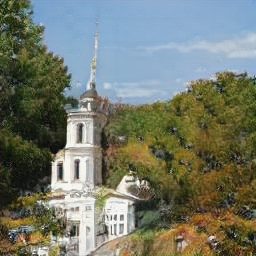

In [4]:
# Load a generator, and paint random image number 20 in a widget.
G = nethook.InstrumentedModel(setting.load_proggan('church')).cuda()
zsamp = zdataset.z_sample_for_model(G, 1000).cuda()

my_z = zsamp[10] # Pick some z from our sample
my_imgdata = G(my_z[None])[0] # Run G on a batch with just this z

# Show the result as an image
show(renormalize.as_image(my_imgdata))

# Exercise 1: Collect GAN internal activations

The following code inspects the internal activations of the gan by retaining its internal layer5 while running it.

The variable `activations` is a tensor containing 131072 numbers, which is too big to understand by just directly looking at the numbers.

In [5]:
PROBE_IMGNUM = 13
probe_z = zsamp[PROBE_IMGNUM][None].cuda()

LAYERNAME = 'layer5'
G.retain_layer(LAYERNAME)
G(probe_z)
activations = G.retained_layer(LAYERNAME)
print(activations.shape)
print('number of elements:', activations.numel())

torch.Size([1, 512, 16, 16])
number of elements: 131072


We can visualize some of the activations directly by building static visualizations.  The following code just sorts through the units and visualizes one of the highest-activating ones.

Our next step will be to add interactivity.

Highest-activating units: [221, 6, 385, 310, 477, 7, 427, 393, 380, 451]



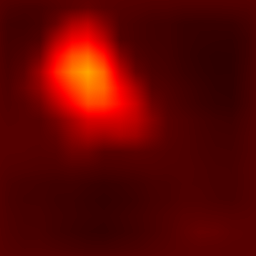

In [6]:
UNIT_NUMBER = 365
print('Highest-activating units:',
      activations.max(3)[0].max(2)[0].sort(1, descending=True)[1][0,:10].tolist())
iv = imgviz.ImageVisualizer(256)
show(['Unit 6', iv.heatmap(activations, (0, 6))])

**Exercise 1**:
   1. How many numbers are contained in the `activations` tensor?  Use `activations.shape` to see its dimensions.
   2. Change the visualization above to visualize other units like 221, 384, or 310.  How do you think these behave on other images?

# Exercise 2: Create a widget to explore by region

It can be hard to understand the representation by just looking the data by-unit.

Instead, let's look by-region.  The following code uses a PaintWidget
that displays an image and also collects a `mask` that can be provided by the user.

**Exercise 2**:
  1. Run the code and interact with the widget.
  2. Change the line where mean is computed (about line 13) to compute
     the (positive) maximum of each channel within the selected
     area, instead of the weighted mean.

Hint: in pytorch, max(dim) returns a pair of (maxval, maxindex).  You want maxval, so `.max(2)[0].max(1)[0]` will take the maximum over the 2nd and 1st dimensions.


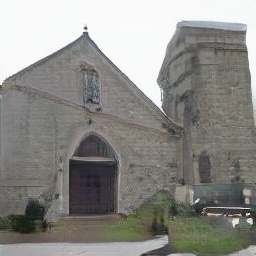

In [7]:
SELECTED_UNITS = []
SELECTED_VALUES = []

# Now let's explore the data interactively.
prober = paintwidget.PaintWidget(oneshot=True)
prober.image = renormalize.as_url(G(zsamp[PROBE_IMGNUM][None])[0])
activations = G.retained_layer(LAYERNAME)
output_div = labwidget.Div('Click and drag above')

def probe_changed(c):
    area = renormalize.from_url(prober.mask, target='pt', size=activations.shape[2:])[0]
    if area.sum() <= 0.0: return
    # original code
    # mean = (activations.cpu()[0] * area[None]).sum(2).sum(1) / area.sum()
    # value, order = mean.sort(0, descending=True)
    # solution code
    maxval = (activations.cpu()[0] * area[None]).max(2)[0].max(1)[0]
    value, order = maxval.sort(0, descending=True)
    global SELECTED_UNITS, SELECTED_VALUES
    SELECTED_UNITS = [o.item() for o in order[:10]]
    SELECTED_VALUES = [v.item() for v in value[:10]]
    output_div.clear()
    output_div.print('SELECTED_UNITS:', SELECTED_UNITS)
    output_div.print('SELECTED_VALUES:', [float('%.2f' % v) for v in SELECTED_VALUES])
prober.on('mask', probe_changed)

show(prober)
show(output_div)

# Exercise 3: Create a way to intervene by region

Now instead of just exploring activations, let's modify them.

The following code adds the SELECTED_VALUES to the SELECTED_UNITS
image just in the area where you paint.  Read the code carefully.

**Exercise 3**: Run the widget and experiment with painting rules.
   1. Can you find SELECTED_UNITS that allow doors to be drawn?  Try probing above using PROBE_IMGNUM of 13 and probing for the active units of the door.
   2. Can you now use these units to draw doors in an image?  Try drawing in CANVAS_IMGNUM 70.  Where can doors be drawn?  Are there places that a door cannot  be drawn?
   3. Now try changing images and regions and units.  Can you draw trees?  Grass?




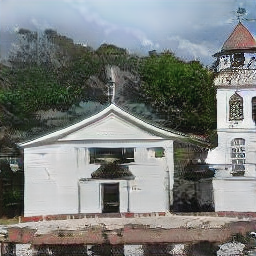

In [8]:
CANVAS_IMGNUM = 70

import torch

G.remove_edits()
canvas_z = zsamp[CANVAS_IMGNUM][None].cuda()
canvas = paintwidget.PaintWidget(
    image=renormalize.as_url(G(canvas_z)[0]),
    oneshot=True
)

def canvas_changed(c):
    global SELECTED_UNITS, SELECTED_VALUES
    if not canvas.mask: return
    area = renormalize.from_url(canvas.mask, target='pt', size=activations.shape[2:])[0]
    def editrule(x, imodel, **buffers):
        x[:,SELECTED_UNITS] += (area[None] * torch.Tensor(SELECTED_VALUES)[:,None,None]).to(x.device)
        return x
    G.edit_layer(LAYERNAME, rule=editrule)
    canvas.image = renormalize.as_url(G(canvas_z)[0])
    G.remove_edits()
canvas.on('mask', canvas_changed)
canvas.brushsize=10
show(canvas)